In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchaudio
import torchaudio_augmentations as ta

import lightning as L
from lightning import LightningModule

import auraloss

import numpy as np
import math

import pandas as pd

from typing import Optional

import os

import utility as U


In [2]:
DEFAULT_INPUT_SR = 16000
DEFAULT_LATENT_SR = 125 # Chosen because 16000 / 2^7 = 125, and we have an even number of 0.5x downsamples
DEFAULT_LATENT_CHANNELS = 16 # Seems to be a pretty standard value for this

DEFAULT_1D_KERNEL_SIZE = 7 # This seems to be standard practice for waveforms
DEFAULT_1D_PADDING = 3 # Padding necessary for kernel size 7 for exact halving of dimensions

DEFAULT_MAX_CHANNELS = 128

DEFAULT_AUDIO_DUR = 20 # In seconds
MAX_SEQ_LEN = 20000

In [3]:
class ELBO_Loss(nn.Module):
    def __init__(self, kl_weight=1e-3):
        super().__init__()
        self.stft_loss = auraloss.freq.MultiResolutionSTFTLoss()
        self.kl_weight = kl_weight

    def forward(self, recon, real, mu, logvar):
        stft = self.stft_loss(recon, real)
        kl = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
        return stft + self.kl_weight * kl


def feature_matching_loss(real_feats, fake_feats):
    loss = 0
    for real, fake in zip(real_feats, fake_feats):
        loss += F.l1_loss(real, fake)
    return loss


In [4]:
class SelfAttention(nn.Module):
    def __init__(self, channels: int, n_heads: int, max_len: int = DEFAULT_AUDIO_DUR * DEFAULT_LATENT_SR):
        """
        Multiheaded self-attention (with residual connections)

        Args:
            channels (int): Channels for input sequence
            n_heads (int): Number of attention heads
        """
        super().__init__()
        self.dim = channels
        self.attn = nn.MultiheadAttention(channels, n_heads, batch_first=True)

        # Precompute positional encodings
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, channels, 2) * -(math.log(10000.0) / channels))
        pe = torch.zeros(max_len, channels)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # shape [1, max_len, channels]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for self-attention (with residual connections)

        B = batch
        C = channels
        T = time
        Args:
            x (torch.Tensor): Sequence tensor of shape [B, C, T]

        Returns:
            torch.Tensor: Tensor of shape [B, C, T]
        """
        B, C, T = x.shape
        x = x.permute(0, 2, 1)  # Reshape to [B, T, C] (expected shape for attention)
        pos_emb = self.pe[:, :T, :]
        attn_in = x + pos_emb
        attn_out, _ = self.attn(attn_in, attn_in, attn_in, need_weights=False)
        return (x + attn_out).permute(0, 2, 1)  # Residual connection, Back to [B, C, T]

class DownsampleLayer(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, activation: str='gelu'):
        super(DownsampleLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.Conv1d(in_channels, out_channels, DEFAULT_1D_KERNEL_SIZE, stride=2, padding=DEFAULT_1D_PADDING)
        self.norm = nn.GroupNorm(out_channels // 4, out_channels)
        self.activation = U.get_activation(activation)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        return x

class VAE_Encoder(nn.Module):
    def __init__(self,
                 input_channels: int,
                 latent_channels: int=DEFAULT_LATENT_CHANNELS,
                 input_sr: int=DEFAULT_INPUT_SR,
                 latent_sr: int=DEFAULT_LATENT_SR):
        """
        Conditional Variational Autoencoder Encoder
        Args:
            input_channels (int): Number of channels for input audio waveforms (ex. stereo vs. mono)
            latent_channels (int): Number of channels for latent audio waveforms
            input_sr (int): Input audio waveform sample rate (16000Hz default)
            latent_sr (int): Target Latent audio sample rate (125Hz default) - No guarantees it'll actually reach this
        """
        super(VAE_Encoder, self).__init__()

        self.input_channels = input_channels
        self.latent_channels = latent_channels
        self.input_sr = input_sr
        self.latent_sr = latent_sr
        self.activation = 'gelu'

        # Input dimension must be some power of 2 multiple of latent dim
        self.n_downsamples = np.ceil(np.log2(self.input_sr / self.latent_sr)).astype(np.int32)
        assert (2 ** self.n_downsamples) * latent_sr == self.input_sr

        starter_channels = 16
        layers = [
            nn.Conv1d(input_channels, starter_channels, DEFAULT_1D_KERNEL_SIZE, stride=1, padding=DEFAULT_1D_PADDING),
            U.get_activation_module('gelu'),
        ]

        # Channels go from 16 -> 32 -> 64 -> DEFAULT_MAX_CHANNELS ... n_downsamples layers
        in_ch = starter_channels
        for i in range(self.n_downsamples):
            out_ch = min(in_ch * 2, DEFAULT_MAX_CHANNELS)
            layers.append(DownsampleLayer(in_ch, out_ch))  # Downsample by factor of 2
            in_ch = out_ch
            layers.append(nn.Conv1d(in_ch, in_ch, DEFAULT_1D_KERNEL_SIZE, stride=1, padding=DEFAULT_1D_PADDING))
            layers.append(U.get_activation_module('gelu'))

        layers.append(SelfAttention(in_ch, 4))

        self.layers = nn.Sequential(*layers)

        self.mu_proj = nn.Sequential(
            nn.Conv1d(in_ch, in_ch, kernel_size=DEFAULT_1D_KERNEL_SIZE, padding=DEFAULT_1D_PADDING),
            U.get_activation_module('gelu'),
            nn.Conv1d(in_ch, latent_channels, kernel_size=1)
        )

        self.logvar_proj = nn.Sequential(
            nn.Conv1d(in_ch, in_ch, kernel_size=DEFAULT_1D_KERNEL_SIZE, padding=DEFAULT_1D_PADDING),
            U.get_activation_module('gelu'),
            nn.Conv1d(in_ch, latent_channels, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        VAE encoder forward pass, input waveforms are expected to be of the correct sample rate (from VAE encoder constructor)

        B = batch size
        C = channels
        T = timesteps

        L = latent space channels
        T' = T * latent_sr / input_sr
        Args:
            x (torch.Tensor): Batch of waveforms of shape [B, C, T]
        Returns:
            Parameters to a diagonal Gaussian in latent space
            torch.Tensor: Latent space tensor of shape [B, L, T'] mean
            torch.Tensor: Latent space tensor of shape [B, L, T'] log variances
        """
        x = self.layers(x)
        return self.mu_proj(x), self.logvar_proj(x)

class UpsampleLayer(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, activation: str='gelu'):
        super(UpsampleLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.upsample = nn.ConvTranspose1d(in_channels, out_channels, DEFAULT_1D_KERNEL_SIZE, stride=2, padding=DEFAULT_1D_PADDING, output_padding=1)
        self.conv = nn.Conv1d(out_channels, out_channels, DEFAULT_1D_KERNEL_SIZE, stride=1, padding=DEFAULT_1D_PADDING)
        self.norm = nn.GroupNorm(out_channels // 4, out_channels)
        self.activation = U.get_activation(activation)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.upsample(x)
        x = self.activation(x)
        x = self.conv(x) + x
        x = self.norm(x)
        x = self.activation(x)
        return x

class VAE_Decoder(nn.Module):
    def __init__(self,
                 input_channels: int,
                 latent_channels: int=DEFAULT_LATENT_CHANNELS,
                 input_sr: int=DEFAULT_INPUT_SR,
                 latent_sr: int=DEFAULT_LATENT_SR):
        """
        Conditional Variational Autoencoder Decoder
        Args:
            input_channels (int): Number of channels for input audio waveforms (ex. stereo vs. mono)
            latent_channels (int): Number of channels for latent audio waveforms
            input_sr (int): Input audio waveform sample rate (16000Hz default)
            latent_sr (int): Target Latent audio sample rate (125Hz default) - No guarantees it'll actually reach this
        """
        super(VAE_Decoder, self).__init__()

        self.input_channels = input_channels
        self.latent_channels = latent_channels
        self.input_sr = input_sr
        self.latent_sr = latent_sr
        self.activation = 'gelu'

        # Input dimensions must be some power of 2 multiple of latent dim
        self.n_upsamples = np.ceil(np.log2(self.input_sr / self.latent_sr)).astype(np.int32)
        assert (2 ** self.n_upsamples) * latent_sr == self.input_sr

        channels = DEFAULT_MAX_CHANNELS
        layers = [
            nn.Conv1d(latent_channels, channels, DEFAULT_1D_KERNEL_SIZE, stride=1, padding=DEFAULT_1D_PADDING),
            U.get_activation_module('gelu'),
        ]

        layers.append(SelfAttention(channels, 4))

        for i in range(self.n_upsamples):
            layers.append(UpsampleLayer(channels, channels))
            layers.append(nn.Conv1d(channels, channels, DEFAULT_1D_KERNEL_SIZE, stride=1, padding=DEFAULT_1D_PADDING))
            layers.append(U.get_activation_module('gelu'))

        layers.append(nn.Conv1d(channels, input_channels, kernel_size=1))

        self.layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        VAE decoder forward pass, input latent space waveforms and outputs waveforms in original input space

        B = batch size
        Z = latent channels
        T = timesteps
        Args:
            x (torch.Tensor): Batch of latent waveforms of shape [B, Z, T']

        Returns:
            torch.Tensor: Reconstruction of waveforms in input space of shape [B, C, T]
        """
        return self.layers(x)

class VAE(nn.Module):
    def __init__(self, audio_channels: int):
        super(VAE, self).__init__()
        self.channels = audio_channels
        self.encoder = VAE_Encoder(audio_channels)
        self.decoder = VAE_Decoder(audio_channels)
        self.latent_dim = self.decoder.latent_channels
        self.latent_sr = self.decoder.latent_sr

    def _sample(self, mu: torch.Tensor, log_var: torch.Tensor):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def generate(self, n_samples: int=1) -> torch.Tensor:
        z = torch.randn([n_samples, self.latent_dim, self.latent_sr * DEFAULT_AUDIO_DUR])
        audio = self.decoder(z)
        return audio

    def forward(self, input: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Full VAE encoder + decoder forward pass

        Args:
            x (torch.Tensor): Batch of waveforms of shape [B, C, T]

        Returns:
            torch.Tensor: Reconstruction of waveforms in input space of shape [B, C, T]
            torch.Tensor: Mean of Gaussian distribution over latent space
            torch.Tensor: Log variance of Gaussian distribution over latent space

        """
        mu, log_var = self.encoder(input)
        sample = self._sample(mu, log_var)
        reconstruction = self.decoder(sample)
        return reconstruction, mu, log_var

In [5]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_channels: int):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv1d(input_channels, 128, 15, stride=1, padding=7),   # preserves resolution
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, 41, stride=4, padding=20, groups=4),   # grouped conv like HiFi-GAN
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, 41, stride=4, padding=20, groups=16),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, 41, stride=4, padding=20, groups=16),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, 41, stride=4, padding=20, groups=16),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 128, 5, stride=1, padding=2),
            nn.LeakyReLU(0.2),
            nn.Conv1d(128, 1, kernel_size=3, stride=1, padding=1)     # patch discriminator output
        ])

    def forward(self, x, return_features=False):
        features = []
        for layer in self.layers:
            x = layer(x)
            features.append(x)
        return (x, features) if return_features else x




class AudioVAEGAN(LightningModule):
    def __init__(self, channels: int, kl_weight: float = 1e-3, adv_weight: float = 1.0, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.automatic_optimization = False

        self.vae = VAE(channels)
        self.discriminator = PatchDiscriminator(channels)

        self.recon_loss = ELBO_Loss(kl_weight)
        self.adv_weight = adv_weight
        self.current_step = 1

    def forward(self, x):
        return self.vae(x)

    # def adversarial_loss(self, pred, target_is_real=True):
    #     target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
    #     return F.binary_cross_entropy_with_logits(pred, target)

    # Hinge loss
    def adversarial_loss(self, pred, target_is_real=True):
        if target_is_real:
            return torch.mean(F.relu(1.0 - pred))
        else:
            return torch.mean(F.relu(1.0 + pred))


    def training_step(self, batch, batch_idx):
        real = batch
        opt_vae, opt_disc = self.optimizers()

        ### === Train Generator (VAE Decoder) === ###
        self.toggle_optimizer(opt_vae)
        recon, mu, logvar = self.vae(real)

        # VAE reconstruction + KL loss
        # stft_weight = min(self.current_step / 10_000, 1.0)
        elbo = self.recon_loss(recon, real, mu, logvar)

        # Discriminator prediction on fake
        d_fake = self.discriminator(recon, False)

        # Adversarial loss
        adv_loss = self.adversarial_loss(d_fake, True)

        # Feature matching loss (from intermediate features)
        _, real_feats = self.discriminator(real, True)
        _, fake_feats = self.discriminator(recon, True)
        fm_loss = feature_matching_loss(real_feats, fake_feats)
        total_gen_loss = elbo + self.adv_weight * adv_loss + 1 * fm_loss


        self.manual_backward(total_gen_loss)
        torch.nn.utils.clip_grad_norm_(self.vae.parameters(), max_norm=1.0)
        opt_vae.step()
        opt_vae.zero_grad()
        self.untoggle_optimizer(opt_vae)

        ### === Train Discriminator === ###
        self.toggle_optimizer(opt_disc)
        with torch.no_grad():
            recon_detached, _, _ = self.vae(real)

        d_real = self.discriminator(real)
        d_fake = self.discriminator(recon_detached)

        # Hinge loss for discriminator
        real_loss = self.adversarial_loss(d_real, True)
        fake_loss = self.adversarial_loss(d_fake, False)
        d_loss = 0.5 * (real_loss + fake_loss)

        self.manual_backward(d_loss)
        torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_norm=1.0)
        opt_disc.step()
        opt_disc.zero_grad()
        self.untoggle_optimizer(opt_disc)

        ### === Logging === ###
        self.log_dict({
            "gen/elbo": elbo,
            "gen/adv": adv_loss,
            # "gen/fm": fm_loss,
            "gen/total": total_gen_loss,
            "disc/loss": d_loss,
        }, prog_bar=True, on_step=True, on_epoch=True)

        self.current_step += 1


    def generate(self, n_samples: int):
        return self.vae.generate(n_samples)

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.vae.parameters(), lr=self.lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr * 2)
        return [opt_g, opt_d]

In [6]:
# # Unused now
# class AudioVAE(LightningModule):
#     def __init__(self, channels: int, kl_weight: float = 1e-3, lr=1e-4):
#         super(AudioVAE, self).__init__()
#         self.vae = VAE(channels)
#         self.loss = ELBO_Loss(kl_weight)
#         self.lr = lr

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.vae(x)

#     def training_step(self, batch, batch_idx=None, dataloader_idx=None) -> torch.Tensor:
#         reconstruction, mu, log_var = self.vae(batch)
#         loss = self.loss(reconstruction, batch, mu, log_var)
#         self.log('training_elbo_loss', loss, prog_bar=True)
#         return loss

#     def generate(self, n_samples: int):
#         return self.vae.generate(n_samples)

#     def configure_optimizers(self):
#         return optim.Adam(self.vae.parameters(), self.lr)

#### Dataset

In [7]:
class GTZANAudioDataset(Dataset):
    def __init__(self, path: str, sample_rate=16000, duration=10):
        """
        Expects a path to .../Data - i.e. the path should end with "Data"
        """
        super().__init__()
        self.path = path
        if not os.path.exists(path):
            import requests
            import zipfile
            # Stream the download to avoid loading the whole file into memory
            with requests.get('https://www.kaggle.com/api/v1/datasets/download/andradaolteanu/gtzan-dataset-music-genre-classification', stream=True) as r:
                r.raise_for_status()  # Raise an error on bad status
                with open('gtzan.zip', 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)

            # TODO: theres a path bug here, im too lazy to fix it, but it unzips the Data one level too deep than it should
            # Ensure the extract_to directory exists
            os.makedirs(path, exist_ok=True)

            # Extract the ZIP file
            with zipfile.ZipFile('gtzan.zip', 'r') as zip_ref:
                zip_ref.extractall(path)

        self.df = pd.read_csv(os.path.join(path, 'features_30_sec.csv'))
        self.min_audio_len = self.df['length'].min()
        self.sample_rate = sample_rate

        # Filter malformed shit
        self.df = self.df[self.df['filename'] != 'jazz.00054.wav']
        self.resampler = torchaudio.transforms.Resample(22050, sample_rate)

        self.sr = sample_rate
        self.target_frames = self.sr * duration

        self.crop = ta.RandomResizedCrop(self.target_frames)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        genre = self.df.iloc[index]['label']
        filename = self.df.iloc[index]['filename']
        path = os.path.join(self.path, 'genres_original', genre, filename)
        waveform, sr = torchaudio.load(path, normalize=True)

        if sr != self.sr:
            waveform = self.resampler(waveform)

        if waveform.size(1) < self.target_frames:
            pad_len = self.target_frames - waveform.size(1)
            waveform = F.pad(waveform, (0, pad_len))
        else:
            waveform = self.crop(waveform)

        return waveform

In [8]:
class MusicDataModule(L.LightningDataModule):
    def __init__(
        self,
        data_dir: str = "./",
        batch_size: int = 1,
        num_workers: int = 1,
        target_sr: int = 16000,
        clip_duration: float = 10.0,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.target_sr = target_sr
        self.clip_duration = clip_duration

    def setup(self, stage: Optional[str] = None):
        self.train_dataset = GTZANAudioDataset(
            self.data_dir,
            16000,
            10
        )

    def _collate_fn(self, batch):
        clips = []
        for clip in batch:
            clips.append(clip)
        return torch.stack(clips)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, collate_fn=self._collate_fn
        )



### Train

In [9]:
dm = MusicDataModule("./Data/Data/Data", batch_size=2, num_workers=6)

In [ ]:
vae = AudioVAEGAN(1, 1e-4, 1) # looks like vegan lol

trainer = L.Trainer()
trainer.fit(vae, datamodule=dm)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/benjx/miniconda3/envs/ldmg/lib/python3.12/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | vae           | VAE                | 3.9 M  | train
1 | discriminator | PatchDiscriminator | 378 K  | train
2 | recon_loss    | ELBO_Loss          | 0      | train
-------------------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.275    Total estimated model params size 

Epoch 0:   0%|          | 0/500 [00:00<?, ?it/s] 

In [ ]:
from IPython.display import Audio, display

def show_wav(waveform, sample_rate):
    display(Audio(waveform, rate=sample_rate))

In [ ]:
tmp = dm.train_dataset[10].unsqueeze(0).to(device='cuda').to(dtype=torch.float32)

In [ ]:
vae = vae.to(device='cuda:0')
with torch.no_grad():
    out, _, _ = vae(tmp)
out = out[0][0].detach().cpu().numpy()
print(np.max(out))

# Example waveform and sample rate
sample_rate = 16000  # in Hz
waveform = out

show_wav(waveform, sample_rate)

0.77886814


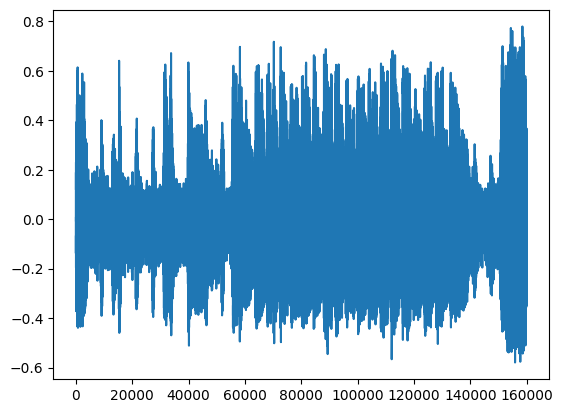

In [ ]:
import matplotlib.pyplot as plt

plt.plot(waveform)

In [ ]:
out = tmp[0][0].detach().cpu().numpy()
print(np.max(out))

# Example waveform and sample rate
sample_rate = 16000  # in Hz
waveform = out

show_wav(waveform, sample_rate)

0.85162026


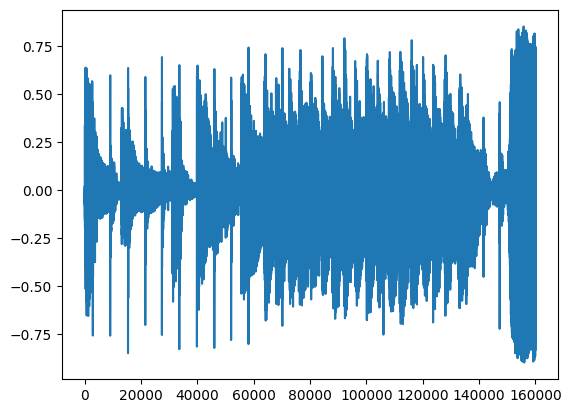

In [ ]:
plt.plot(waveform)